# Implementation of MAXSER

## Step 0: Subpool selection
   1. Form 1000 random subpools of 12 assets
   2. Calculate the adjusted Sharpe ratio, $\hat{\theta}_{adj}$: $$\hat{\theta}_{adj} = \frac{(T-N-2)\hat{\theta}_s-N}{T}+\frac{2(\hat{\theta}_s-N)^{N/2}+(1+\hat{\theta}_s-N)^{-(T-2)/2}}{TB_{\hat{\theta}_s-N/(1+\hat{\theta}_s-N)}(N/2,(T-N)/2)}$$
      where $\hat{\theta}_s$ is the sample estimate of the Sharpe ratio $$\hat{\theta}_s:=\mathbf{\hat{\mu}}'\mathbf{\hat{\Sigma}}^{-1}\mathbf{\hat{\mu}}$$
      and $$B_x(a,b) = \int_0^x y^{a-1}(1-y)^{b-1}dy$$
   3. Select the subpool with $\hat{\theta}_{adj}$ corresponding to 95th percentile.

## Step 1 
   1. Estimate the square of the maximum Sharpe ratio by $\hat{\theta}_{adj}$
   2. Compute response $$\hat{r}_c := \sigma\frac{1+\hat{\theta}}{\sqrt{\hat{\theta}}}$$
   where $\sigma$ is a given risk constraint (i.e. target risk level), and $$\hat{\theta}:=\frac{(T-N-2)\hat{\theta}_s-N}{T}$$

## Step 2
   1. Split the sample into 10 random groups and select $\lambda$ through 10-fold cross-validation:
      - For each training set $i$, obtain the whole solution path $(\mathbf{\omega}_{0≤\zeta≤1})$ (using LARS?)
      - Calculate the difference between the risk computed using the validation set and the given risk constraint
      - $\hat{\zeta}$ is taken to be the average of $\zeta(i), i = 1,\dots,10$
      - Denote selected value by $\hat{\lambda}$
   
## Step 3
   1. Use the estimated $\hat{\lambda}$ in $$\hat{\mathbf{\omega^*}} = \underset{\mathbf{\omega}}{\mathrm{argmin}}\frac{1}{T}\sum_{t=1}^T(\hat{r}_c-\mathbf{\omega}'\mathbf{R_t})^2\quad \text{subect to} \quad ||\mathbf{\omega}||_1≤\hat{\lambda}$$ and solve for the MAXSER portfolio weights $\hat{\mathbf{\omega^*}}$

In [92]:
import numpy as np
import pandas as pd
from scipy.stats import beta
from sklearn.model_selection import KFold
from sklearn.linear_model import LassoCV

data = pd.read_csv('48_Industry_Portfolios.csv', skiprows=11, nrows=1181, index_col=0)
data.index = pd.to_datetime(data.index, format='%Y%m')
data = data.iloc[-60:]      # use last 60 observations (5 years)

rf_data = pd.read_csv('F-F_Research_Data_Factors.csv', skiprows=3, nrows=1181, index_col=0)
rf_data.index = pd.to_datetime(rf_data.index, format='%Y%m')
rf_data.tail()

,Mkt-RF,SMB,HML,RF
2024-07-01,1.24,6.80,5.74,0.45
2024-08-01,1.61,-3.55,-1.13,0.48
2024-09-01,1.74,-0.17,-2.59,0.40
2024-10-01,-0.97,-1.01,0.89,0.39
2024-11-01,6.50,4.63,-0.05,0.40


In [93]:
rf = 0.40                       # most recent risk free rate from factor dataset
data_excess = data - rf         # compute excess returns
data_excess = data_excess / 100 # convert to percentage
data_excess.head()

,Agric,Food,Soda,Beer,Smoke,Toys,Fun,Books,Hshld,Clths,...,Boxes,Trans,Whlsl,Rtail,Meals,Banks,Insur,RlEst,Fin,Other
2019-12-01,0.1074,0.0266,0.0357,0.0099,0.0282,-0.0142,0.0451,0.0286,0.0219,0.0718,...,0.0019,-0.0062,0.0204,0.0081,0.0187,0.0285,0.0181,0.0518,0.0039,0.0133
2020-01-01,-0.0371,-0.0178,0.0481,0.0230,-0.0406,-0.0377,0.0061,-0.0474,-0.0001,-0.0581,...,-0.0137,-0.0055,-0.0339,0.0074,0.0110,-0.0410,-0.0326,-0.0226,0.0258,0.0042
2020-02-01,-0.0651,-0.0970,-0.0859,-0.0787,-0.0711,-0.1751,-0.0408,-0.0705,-0.0886,-0.0994,...,-0.0762,-0.1129,-0.0977,-0.0643,-0.0976,-0.1189,-0.0928,-0.1045,-0.1087,-0.0883
2020-03-01,-0.1152,-0.0464,-0.1584,-0.1032,-0.0716,-0.1925,-0.1669,-0.2305,-0.0715,-0.1986,...,-0.1009,-0.1721,-0.1822,-0.0488,-0.2252,-0.2430,-0.1314,-0.3635,-0.1726,-0.1539
2020-04-01,0.0919,0.0820,0.0436,0.1054,0.0158,0.1763,0.1427,0.0799,0.0986,0.1073,...,0.0731,0.0822,0.1211,0.1839,0.1827,0.1101,0.1145,0.1241,0.1330,0.0191


In [94]:
# calculate standard deviation of excess returns for entire portfolio
std = data_excess.std().values
sigma = std.mean().round(2)
sigma

0.08

In [95]:
# Step 0: Subpool Selection
def adjusted_sharpe_ratio(theta_s, T, N):
    B = beta.cdf(theta_s / (1 + theta_s), N / 2, (T - N) / 2)
    return ((T - N - 2) * theta_s - N) / T + (2 * (theta_s - N) ** (N / 2) + (1 + theta_s - N) ** (-(T - 2) / 2)) / (T * B)

def subpool_selection(data, num_subpools=1000, pool_size=12):
    T, N = data.shape
    subpool_sharpes = []
    for _ in range(num_subpools):
        subpool_indices = np.random.choice(N, pool_size, replace=False)
        subpool = data.iloc[:, subpool_indices]
        mu = subpool.mean(axis=0)
        cov = subpool.cov()
        theta_s = np.dot(mu.T, np.linalg.solve(cov, mu))
        theta_adj = adjusted_sharpe_ratio(theta_s, T, pool_size)
        subpool_sharpes.append((theta_adj, subpool_indices))

    subpool_sharpes.sort(reverse=True, key=lambda x: x[0])
    percentile_index = int(0.95 * len(subpool_sharpes)) - 1
    return subpool_sharpes[percentile_index][0], subpool_sharpes[percentile_index][1]  

best_theta_adj, best_subpool_indices = subpool_selection(data_excess)

In [96]:
# Step 1: Calculate adjusted Sharpe ratio and response
def calculate_response(data, sigma, subpool_indices):
    T, N = data.shape
    mu = data.mean(axis=0)
    cov = data.cov()
    theta_s = np.dot(mu[subpool_indices].T, np.linalg.solve(cov.iloc[subpool_indices, subpool_indices], mu[subpool_indices]))
    theta_hat = ((T - len(subpool_indices) - 2) * theta_s - len(subpool_indices)) / T
    response = sigma * (1 + theta_hat) / np.sqrt(theta_hat)
    return response

# sigma = 0.04  # From Ao et al.
response = calculate_response(data_excess, sigma, best_subpool_indices)

/var/folders/c5/0k9q6ymj10d7tsm7thk3_yqr0000gn/T/ipykernel_99080/3884558549.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  theta_s = np.dot(mu[subpool_indices].T, np.linalg.solve(cov.iloc[subpool_indices, subpool_indices], mu[subpool_indices]))


In [97]:
# Step 2: Cross-validation to select lambda
kf = KFold(n_splits=10, shuffle=True, random_state=42)
def select_lambda(data, response):
    X = data.values
    y = np.full(X.shape[0], response)

    lasso = LassoCV(cv=kf, max_iter=10000).fit(X, y)
    return lasso.alpha_

lambda_hat = select_lambda(data_excess, response)
print(lambda_hat)

/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:683: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent_gram(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:683: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent_gram(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:683: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent_gram(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:683: ConvergenceWarning: Objective did not converge. You might want to increase the num

1e-15


/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:683: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent_gram(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:683: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent_gram(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:683: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent_gram(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:683: ConvergenceWarning: Objective did not converge. You might want to increase the num

MAXSER Portfolio Weights:
Agric    0.000000e+00
Food     0.000000e+00
Soda     6.938894e-18
Beer     3.122502e-17
Smoke    4.857226e-17
Toys     2.775558e-17
Fun      0.000000e+00
Books    0.000000e+00
Hshld    8.673617e-17
Clths    0.000000e+00
Hlth     6.591949e-17
MedEq    3.469447e-18
Drugs    1.734723e-17
Chems    0.000000e+00
Rubbr    0.000000e+00
Txtls    3.816392e-17
BldMt    3.469447e-18
Cnstr    0.000000e+00
Steel    0.000000e+00
FabPr    6.938894e-18
Mach     0.000000e+00
ElcEq    0.000000e+00
Autos    0.000000e+00
Aero     2.081668e-17
Ships    1.040834e-17
Guns     3.469447e-18
Gold     3.469447e-18
Mines    0.000000e+00
Coal     1.002670e-15
Oil      3.469447e-18
Util     1.040834e-17
Telcm    0.000000e+00
PerSv    0.000000e+00
BusSv    0.000000e+00
Comps    3.469447e-18
Chips    0.000000e+00
LabEq    0.000000e+00
Paper    1.040834e-17
Boxes    0.000000e+00
Trans    0.000000e+00
Whlsl    1.040834e-17
Rtail    1.040834e-17
Meals    0.000000e+00
Banks    0.000000e+00
Insur 

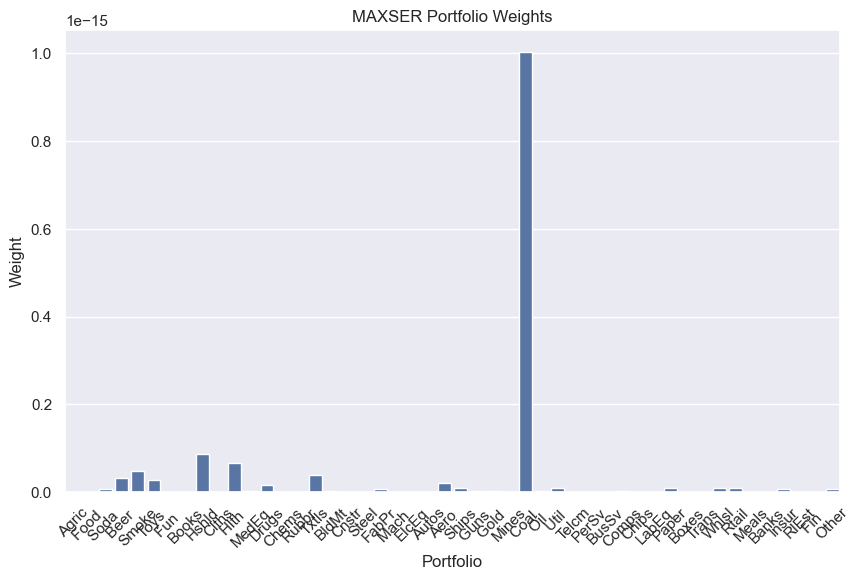

In [98]:
# Step 3: Solve for MAXSER portfolio weights
def maxser_weights(data, response, lambda_val):
    from scipy.optimize import minimize

    X = data.values
    y = np.full(X.shape[0], response)

    def loss_fn(weights):
        return np.mean((y - X @ weights) ** 2)

    constraints = ({'type': 'ineq', 'fun': lambda w: lambda_val - np.sum(np.abs(w))})
    bounds = [(0, None)] * data.shape[1]

    result = minimize(loss_fn, np.ones(data.shape[1]) / data.shape[1], bounds=bounds, constraints=constraints)
    return result.x

weights = maxser_weights(data_excess, response, lambda_hat)

# Final portfolio weights
portfolio_weights = pd.Series(weights, index=data_excess.columns)
print("MAXSER Portfolio Weights:")
print(portfolio_weights)

# visualize portfolio weights
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

plt.figure(figsize=(10, 6))
sns.barplot(x=portfolio_weights.index, y=portfolio_weights.values)
plt.xticks(rotation=45)
plt.title("MAXSER Portfolio Weights")
plt.xlabel("Portfolio")
plt.ylabel("Weight")
plt.show()